<a href="https://colab.research.google.com/github/AlirezaTabaei/SVHNImaging/blob/main/SVHN_Cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the SVHN dataset

In [ ]:
!pip install wget
import wget

In [ ]:
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

train_data = wget.download(train_url)
test_data = wget.download(test_url)

In [ ]:
train_data

'train_32x32.mat'

In [ ]:
from scipy.io import loadmat
data_train = loadmat(train_data)
data_test = loadmat(test_data)

## EDA

In [ ]:
type(data_train), type(data_test)

(dict, dict)

In [ ]:
# a dic has three attributes: .items() / .keys() / .values()
data_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [ ]:
data_test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [ ]:
X_train = data_train['X']
X_test = data_test['X']

y_train = data_train['y']
y_test = data_test['y']

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train.shape

(32, 32, 3, 73257)

In [ ]:
# pip install matplotlib
import matplotlib.pyplot as plt

def image_viz(X, y):
    fig, axes = plt.subplots(2, 5, figsize=(12,6))
    # flatten the axes array for easy indexing
    axes = axes.ravel()
    for i in range(10):
        img = X[:, :, :, i]
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off') # remove the ticks on axis
    plt.tight_layout()
    plt.show()

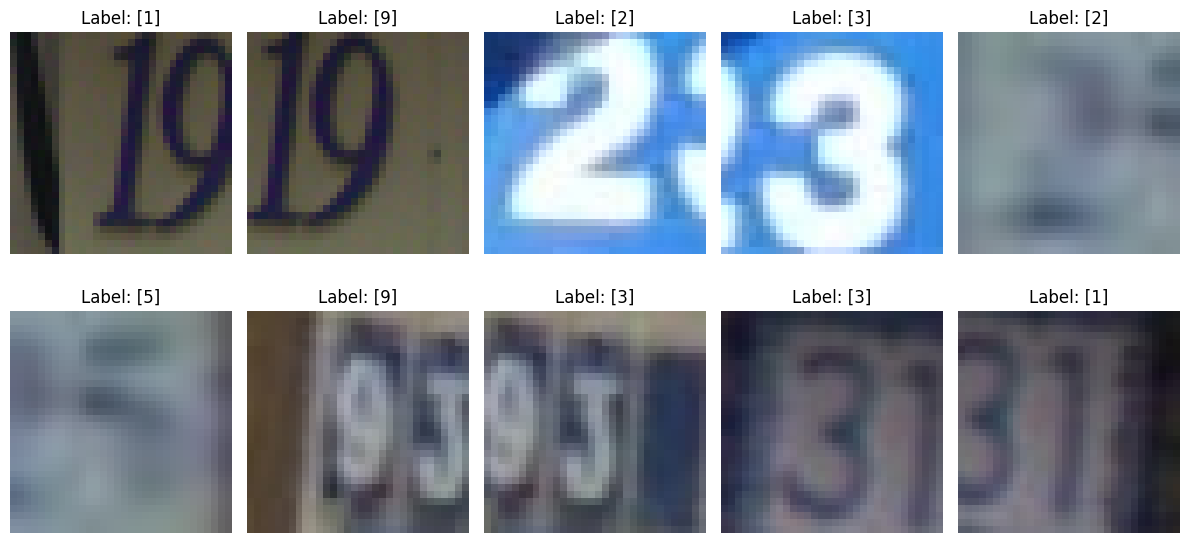

In [ ]:
image_viz(X_train, y_train)

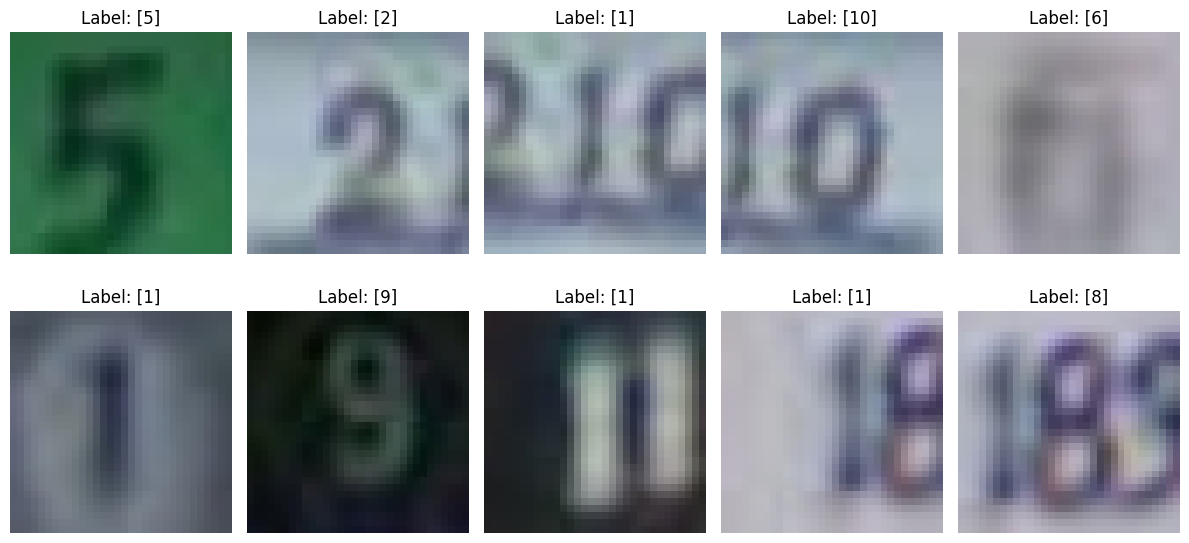

In [ ]:
image_viz(X_test, y_test)

In [ ]:
# check the y distribution (to see if the dataset is imbalance)
import numpy as np
def label_dist(y):
    unique_labels, counts = np.unique(y, return_counts=True)
    return dict(zip(unique_labels, counts))

In [ ]:
train_dist = label_dist(y_train)
test_dist = label_dist(y_test)

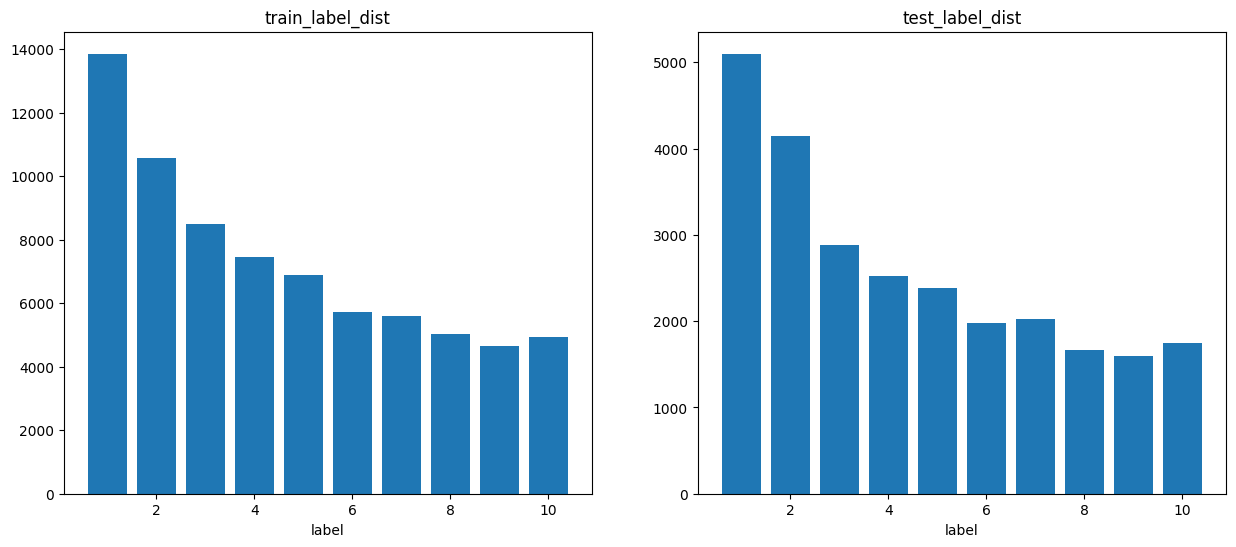

In [ ]:
plt.figure(figsize=(15,6), dpi=100)
plt.subplot(1, 2, 1)
plt.bar(train_dist.keys(), train_dist.values())
plt.title("train_label_dist")
plt.xlabel("label")
plt.subplot(1, 2, 2)
plt.bar(test_dist.keys(), test_dist.values())
plt.title("test_label_dist")
plt.xlabel("label");

In [ ]:
X_train.min(), X_train.max()

(0, 255)

## Preprcessing

In [ ]:
## Normalization
def normalizer(X):
    X = X / 255
    return X


In [ ]:
X_train_norm = normalizer(X_train)
X_test_norm = normalizer(X_test)

In [ ]:
np.shape(X_train_norm)

(32, 32, 3, 73257)

In [ ]:
# gray_scale
def convert_gray(X):
    return np.mean(X, axis=2, keepdims=True)

In [ ]:
X_train_norm_gray = convert_gray(X_train_norm)
X_test_norm_gray = convert_gray(X_test_norm)
np.shape(X_train_norm_gray)

(32, 32, 1, 73257)

In [ ]:
# reshape to prepare the inputs for ML models
def reshape(X):
    return X.transpose(3, 0, 1, 2).reshape(np.shape(X)[3], -1)

X_tr = reshape(X_train_norm_gray)
X_ts = reshape(X_test_norm_gray)

X_tr_rgb = reshape(X_train_norm)
X_ts_rgb = reshape(X_test_norm)

In [ ]:
X_tr.shape, X_tr_rgb.shape

((73257, 1024), (73257, 3072))

In [ ]:
# Train Phase
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=20, n_estimators=100)
rf_clf.fit(X_tr, y_train)

In [ ]:
# Test phase
from sklearn.metrics import accuracy_score
y_pred = rf_clf.predict(X_ts)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_tr)
# transform
X_tr_pca = pca.transform(X_tr)
X_ts_pca = pca.transform(X_ts)

In [ ]:
variances = pca.explained_variance_ratio_

In [ ]:
variances

array([6.06703902e-01, 5.97587652e-02, 4.87212300e-02, ...,
       4.43992325e-08, 4.25845412e-08, 4.20103008e-08])

In [ ]:
cum_variances = np.cumsum(variances)

In [ ]:
# cumulative percentage of compnents' importance
cum_variances

array([0.6067039 , 0.66646267, 0.7151839 , ..., 0.99999992, 0.99999996,
       1.        ])

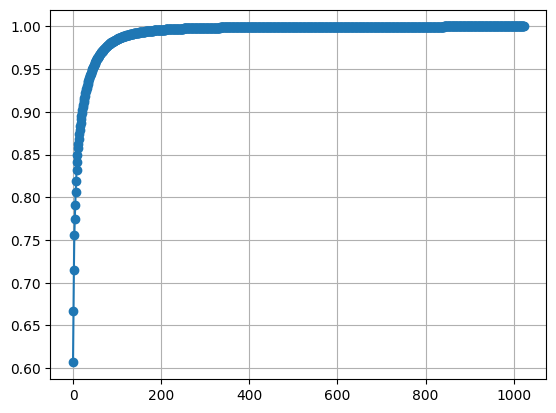

In [ ]:
plt.plot(cum_variances, marker='o')
plt.grid()

In [ ]:
component_90 = np.argmax(cum_variances > 0.9) + 1

In [ ]:
pca_90 = PCA(n_components=component_90)
X_tr_90 = pca_90.fit_transform(X_tr)
X_ts_90 = pca_90.transform(X_ts)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=20, n_estimators=100)
rf_clf.fit(X_tr_90, y_train)

C:\Users\rezas\AppData\Local\Temp\ipykernel_18216\2359507840.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_tr_90, y_train)


RandomForestClassifier(max_depth=20)

In [ ]:
# Test phase
from sklearn.metrics import accuracy_score
y_pred = rf_clf.predict(X_ts_90)
accuracy_score(y_test, y_pred)

0.5891979102642901

In [ ]:
y_train_0 = np.where(y_train==10, 0, y_train)
y_test_0 = np.where(y_test==10, 0, y_test)

In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=200)
xgb_clf.fit(X_tr_90, y_train_0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgb_clf.predict(X_ts_90)
accuracy_score(y_test_0, y_pred)

0.6548862937922557

In [ ]:
!pip install optuna

In [ ]:
import xgboost as xgb
import optuna
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_train_0)),
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }


    model = xgb.XGBClassifier(**params, tree_method='gpu_hist')
    model.fit(X_tr_90, y_train_0)
    y_pred_proba = model.predict_proba(X_ts_90)
    loss = log_loss(y_test_0, y_pred_proba)
    print('Loss:', loss)
    return loss


run=1

if run==1:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    print('Best trial:')
    trial = study.best_trial

    print('Value: {}'.format(trial.value))
    print('Params: ')
    for key, value in trial.params.items():
        print(' {}: {}'.format(key, value))

In [ ]:
Params = {
 'booster': 'dart',
 'lambda': 1.0242666594791542e-06,
 'alpha': 0.7463356396884083,
 'max_depth': 9,
 'eta': 0.14340443962292507,
 'gamma': 2.113646020026708e-06,
 'colsample_bytree': 0.7796509234122975,
 'min_child_weight': 6.482091531227992,
 'subsample': 0.8788610015127709,
 'n_estimators': 136}

In [ ]:
x = xgb.XGBClassifier(**Params, tree_method='gpu_hist')

x.fit(X_tr_rgb, y_train_0)
accuracy_score(y_test_0, x.predict(X_ts_rgb))

0.7383988936693301

In [7]:
!git commit -a -m "Hyperparameter tuning on xgboost"

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# imbalance handling
# hyperparameter tunning
# experiment 3-ch
# different models (clf, dim reduction)
# NNs
# Viz 2d after pca
# deployment